# Run CAD model on real dataset<sup>1,2</sup>
### Dataset cannot be automatically downloaded, please sign data use agreement here: https://physionet.org/content/ct-ich/1.3.1/

1. Hssayeni, M. (2020). Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation (version 1.3.1). PhysioNet. https://doi.org/10.13026/4nae-zg36.
2. Goldberger, A., et al (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [ ]:
# load and create dataframes

import os
import sys
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

from image_utils import *
from model_utils import *

path = Path('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/') # TODO: change directory
scan_path = Path.joinpath(path, 'ct_scans')

/home/jayse.weaver/anaconda3/envs/insilicoCAD/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Processing with model CAD_1
Processing with model CAD_2
Processing with model CAD_3


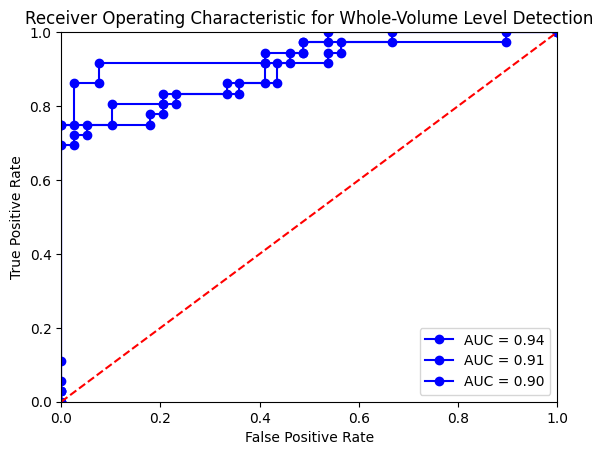

In [ ]:
# Run CAD on real data
label_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': True
}

prepath = Path(os.environ['MODEL_PATH'])
model_names = ['CAD_1', 'CAD_2', 'CAD_3']
# model_names = ['CAD_1'] # run on 'original' model weights

for model in model_names:
    print('Processing with model ' + str(model))
    # load a modified version of Patient_demographics with cleaner headers
    df = pd.read_csv('../datasets/MODIFIED_Patient_demographics.csv')
    df = df.drop(df.columns[4:], axis=1) # remove lesion types
    df.loc[df['Any_ICH'] != 0, 'Any_ICH'] = 1 # change # of ICH subtypes to binary 1/0
    df['Model_Output'] = np.nan # add model output column

    # there are six patients in Patient_demographics.csv with no images in the dataset; remove them
    no_ct = [59, 60, 61, 61, 62, 63, 64, 65]
    for case in no_ct:
        df.drop(df[df['Patient Number'] == case].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

    model_path = prepath / model 

    if os.path.isfile('../datasets/' + model + '_real_preds.csv'):
        df = pd.read_csv('../datasets/' + model + '_real_preds.csv')
    else:
        with tqdm(total=len(df)) as pbar:
            for index, row in df.iterrows():

                pbar.update(1)

                nifti_path = Path.joinpath(scan_path, str(row['Patient Number']).zfill(3) + '.nii')

                img, files = prepare_images(nifti_path, options, str(row['Patient Number']).zfill(3), 'saved_images/')
                output = classify_images(img, options, model_path, device='cuda')
                
                df.loc[index, 'Model_Output'] = np.max(output[:, -1])


        if options['save_csv']:
            df.to_csv('../datasets/' + model + '_real_preds.csv')

    results_real = df[["Any_ICH", "Model_Output"]].to_numpy()

    # Get ROC
    fpr_real, tpr_real, thresholds_real = metrics.roc_curve(df["Any_ICH"].to_numpy(), df["Model_Output"].to_numpy(), pos_label=1)
    roc_df_real = pd.DataFrame(zip(fpr_real, tpr_real, thresholds_real),columns = ["FPR","TPR","Threshold"])

    roc_auc = metrics.auc(fpr_real, tpr_real)

    plt.plot(fpr_real, tpr_real, 'bo-', label = 'AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic for Whole-Volume Level Detection')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Run CAD model on synthetic datasets

In [ ]:
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_dcm': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': False # synthetic data is 1 mm, "True" will reformat to 5 mm
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device ' + str(device))

dataset_path = os.environ.get('BASE_DIR')
dataset_names = ['test_3']

save_dir = 'temp_images/new/' # optional save directory if save_jpg or save_dcm = True

model_names = ['CAD_3', 'CAD_2', 'CAD_1']
# model_names = ['CAD_1'] # run on 'original' model weights

for model in model_names:
    print('Processing with model ' + str(model))
    model_path = prepath + model + '/'
    for dataset in dataset_names:
        print('Processing dataset: ' + str(dataset))
        path = dataset_path / dataset
        metadata = pd.concat([pd.read_csv(o) for o in path.rglob('metadata*.csv')], ignore_index=True)

        if options['save_csv']: metadata.to_csv(path / (str(dataset) + '_' + model + '_metadata.csv'))

        metadata_short = metadata.drop(metadata.columns[12:], axis=1)
        metadata_dropna = metadata_short.dropna()

        cases = sorted(os.listdir(path))
        cases = [case for case in cases if case.startswith('case')]

        # initialize empty lists for results CSV
        attenuation_list = []
        volume_list = []
        type_list = []
        labels_list = []
        preds_list = []

        if options['native_resolution']:
            print('Processing in native resolution')
        else:
            print('Processing in 5 mm resolution')

        max_count = len(cases)
        description = 'Processing ' + str(len(cases)) + ' cases'

        with tqdm(total=max_count) as pbar:
            for index, case in enumerate(cases):

                pbar.update(1)

                id = str(case)
                if os.path.isdir(Path.joinpath(path, case, 'lesion_masks/')): # check if case has mask and therefore hemorrhage
                    try:
                        # if case has hemorrhage, extract metadata from dataframe
                        # TODO: fix insilicoICH metadata generation (currently messy with added strings and brackets)
                        temp_df = metadata_dropna.loc[metadata_dropna['Name'] == case]
                        
                        attenuation = float(temp_df['LesionAttenuation(HU)'].unique()[0].replace('[','').replace(']',''))
                        volume = temp_df['LesionVolume(mL)'].apply(lambda x: x.replace('[','').replace(']','')).astype(float).sum()
                        lesion_type = temp_df['Subtype'].unique()[0].replace('[','').replace(']','')

                        # try extracting all metadata before appending
                        attenuation_list.append(attenuation)
                        volume_list.append(volume)
                        type_list.append(lesion_type)
                        labels_list.append(1)
                    except:
                        print('Error')
                        attenuation_list.append('NaN')
                        volume_list.append('NaN')
                        type_list.append('None')
                        labels_list.append(0)
                       
                else: # case has no mask, therefore no hemorrhage
                    attenuation_list.append('NaN')
                    volume_list.append('NaN')
                    type_list.append('None')
                    labels_list.append(0)

                dcm_path = Path.joinpath(path, case, 'dicoms/')

                img, files = prepare_images(dcm_path, options, id, save_dir)

                output = classify_images(img, options, model_path, device)
                preds_list.append(np.max(output[:, -1]))

                if options['verbose']: print(np.max(output[:, -1]))

        fpr_syn, tpr_syn, thresholds_syn = metrics.roc_curve(labels_list, preds_list, pos_label=1)
        roc_df_syn = pd.DataFrame(zip(fpr_syn, tpr_syn, thresholds_syn),columns = ["FPR","TPR","Threshold"])

        roc_auc_syn = metrics.auc(fpr_syn, tpr_syn)

        all_cases = cases.copy()

        dfsyn = pd.DataFrame()
        dfsyn['Name'] = all_cases
        dfsyn['TruthLabel'] = labels_list
        dfsyn['ModelPrediction'] = preds_list
        dfsyn['LesionAttenuation(HU)'] = attenuation_list
        dfsyn['LesionVolume(mL)'] = volume_list
        dfsyn['Subtype'] = type_list

        if options['save_csv']: dfsyn.to_csv(path / (str(dataset) + '_' + model + '_results.csv'))
        
        # another optional CSV - this is just the FPR, TPR, and thresholds that can easily be created again from *_results.csv
        # if options['save_csv']: roc_df_syn.to_csv(path / (str(dataset) + '_ROC.csv'))

using device cpu
Processing with model CAD_3
Processing dataset: test_3
Processing in 5 mm resolution


100%|██████████| 4/4 [02:52<00:00, 43.23s/it]


Processing with model CAD_2
Processing dataset: test_3
Processing in 5 mm resolution


100%|██████████| 4/4 [02:29<00:00, 37.26s/it]


Processing with model CAD_1
Processing dataset: test_3
Processing in 5 mm resolution


100%|██████████| 4/4 [02:25<00:00, 36.37s/it]


# ROC plot generation in create_ROC.ipynb